In [6]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import flt

In [7]:
def cl2xi(cl: np.ndarray, closed = False):
    ls = np.arange(0, len(cl))
    factorcl = (2*ls+1)/(4*np.pi)
    coeffs = cl*factorcl
    return flt.idlt(coeffs, closed = closed)


def theta(n, closed = False):
    '''
    Returns the theta for which the cl2xi are calculated, for a given n
    '''
    return flt.theta(n, closed = closed)


def xi2cl(xi: np.ndarray, closed = False):
    ls = np.arange(0, len(xi))
    factorcl = (2*ls+1)/(4*np.pi)
    return flt.dlt(xi, closed = closed)/factorcl

In [26]:
theta(4000)

array([3.92699082e-04, 1.17809725e-03, 1.96349541e-03, ...,
       3.13962916e+00, 3.14041456e+00, 3.14119995e+00])

In [8]:
def get_mean_from_map(mappa: np.ndarray):
    return np.mean(mappa)

def get_variance_from_map(mappa: np.ndarray):
    return np.mean(mappa**2.)-np.mean(mappa)**2.

def get_skew_from_map(mappa: np.ndarray):
    return np.mean((mappa-get_mean_from_map(mappa))**3.)/np.mean(mappa**2.)**1.5

def y_skew(skew):
    '''
    Formula (12) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    result = 2+skew**2.+skew*np.sqrt(4+skew**2.)
    result /= 2
    return np.power(result, 1/3.)

def get_lambda_from_skew(skew, var, mu):
    lmbda = np.sqrt(var)/skew*(1+y_skew(skew)+1/y_skew(skew))-mu
    return lmbda 

def get_alpha(mu, lmbda):
    '''
    Below formula (7) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    return mu+lmbda

def get_mu_gauss(alpha, var):
    '''
    Gets the mu parameter for the Gaussian distribution for the log-normal
    '''
    result = np.log(alpha**2./np.sqrt(var+alpha**2.))
    return result

def get_sigma_gauss(alpha, var):
    '''
    Gets the sigma parameter for the Gaussian distribution for the log-normal.

    Here the variance is the variance of the wanted log-normal field.
    '''
    result = np.log(1+var/alpha**2.)
    result = np.sqrt(result)
    return result

In [10]:
suppress = lambda l, lsup, supindex: np.exp(-1.0*np.power(l/lsup, supindex))

def process_cl(inputcl: np.ndarray, lsup: float = 7000, supindex: float = 10):
    ls = np.arange(0, len(inputcl))
    result = inputcl*suppress(ls, lsup, supindex)
    return result
    
def get_alpha(mu, lmbda):
    '''
    Below formula (7) from https://arxiv.org/pdf/1602.08503.pdf
    '''
    return mu+lmbda



def create_lognormal_single_map(inputcl: np.ndarray, nside: int, lmax_gen: int, mu: float = 0.0, lamb: float = 0.0):
    alpha = get_alpha(mu, lamb)
    xisinput = cl2xi(inputcl)/alpha/alpha

    xigaussian = np.log(xisinput+1)
    clgaussian = xi2cl(xigaussian)

    vargauss = np.dot(np.arange(1, 2*len(clgaussian), 2), clgaussian)/(4*np.pi)

    lmax_gen = 2*nside-1 if lmax_gen is None else lmax_gen
    almgaussian = hp.synalm(clgaussian, lmax = lmax_gen) #GENERATE TO HIGH LMAX
    maps = hp.alm2map(almgaussian, nside = nside, pol = False)
    
    #vargauss = np.array([xigaussian[i, i][0] for i in range(Nfields)])
    #vargauss = np.array([np.var(m) for m in maps])

    expmu = (mu+lamb)*np.exp(-vargauss*0.5)
    maps = np.array(maps)
    maps = np.exp(maps) 
    maps *= expmu
    maps -= lamb
    return maps


In [21]:
def get_gaussian_xi(inputcl: np.ndarray, mu: float = 0.0, lamb: float = 0.0):
    alpha = get_alpha(mu, lamb)
    xisinput = cl2xi(inputcl)/alpha/alpha

    xigaussian = np.log(xisinput+1)
    return xigaussian

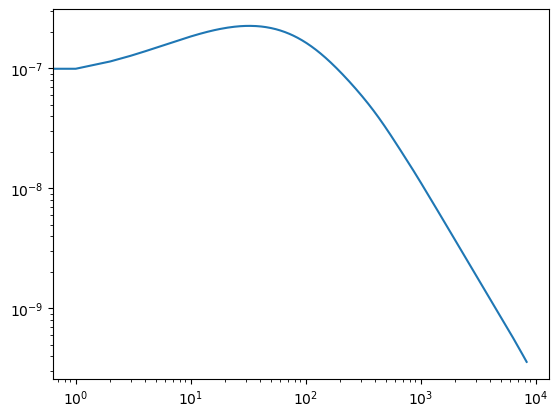

In [11]:
inputs_data_camb = np.loadtxt("../input/giulio/lensedCMB_dmn1_lenspotentialCls.dat")
lscamb = inputs_data_camb[:, 0]
kk = inputs_data_camb[:, 5]
kk *= np.pi/2
plt.loglog(kk)

Text(0, 0.5, '$C_{\\ell}$')

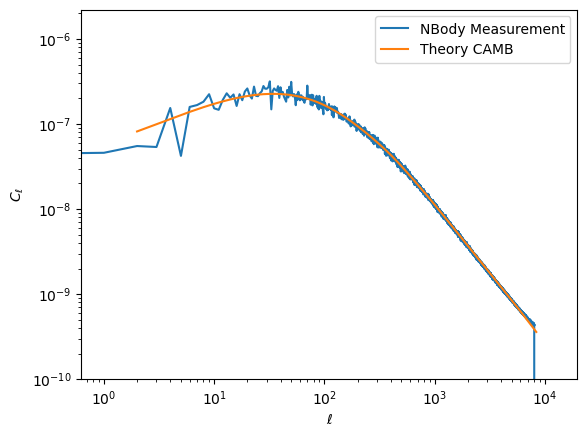

In [12]:
input_data = np.loadtxt("kappa_first.txt")
ls = np.arange(0, len(input_data))
plt.loglog(ls, input_data, label = 'NBody Measurement')
plt.loglog(lscamb, kk, label = 'Theory CAMB')
plt.ylim(1e-10)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [13]:
input_spectrum = input_data #process_cl(input_data)

Text(0, 0.5, '$C_{\\ell}$')

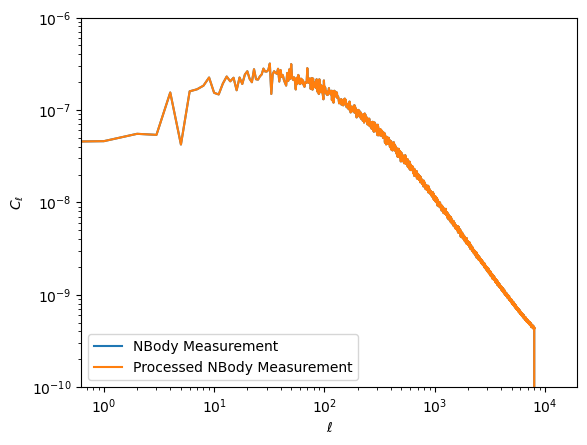

In [14]:
plt.loglog(ls, input_data, label = 'NBody Measurement')
plt.loglog(ls, input_spectrum, label = 'Processed NBody Measurement')
plt.ylim(1e-10, 1e-6)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [15]:
input_map = "/Users/omard/Downloads/SCRATCHFOLDER/giuliosims/map0_kappa_ecp262_dmn2_lmax8000_first.fits"
mappa = hp.read_map(input_map)
#hp.mollview(mappa, title = 'Input Map')

In [27]:
np.mean((mappa-np.mean(mappa))**3)

0.00026611195

In [153]:
fwhms = 0.5 #arcmin
fwhms_deg = fwhms/60 #arcmin to deg
fwhm_rad = np.deg2rad(fwhms_deg)
smoothed_input = hp.sphtfunc.smoothing(mappa, fwhm_rad, pol = False)

In [17]:
smoothed_input = mappa

In [18]:
skewness = get_skew_from_map(smoothed_input)
variance = get_variance_from_map(smoothed_input)
mean = get_mean_from_map(smoothed_input)
lamb = get_lambda_from_skew(skewness, variance, mean)

alpha = get_alpha(mean, lamb)
sigmaG = get_sigma_gauss(alpha, variance)
muG = get_mu_gauss(alpha, variance)

In [19]:
#shifted log-normal distribution
def shifted_lognormal_zero_mean(x, sigmaG, lamb):
    #equation (22) of https://www.aanda.org/articles/aa/pdf/2011/12/aa17294-11.pdf
    return np.exp(-(np.log(x/lamb+1)+sigmaG**2/2)**2./(2.*sigmaG**2.))/(x+lamb)/sigmaG/np.sqrt(2.*np.pi)*(x>-lamb)

def get_out_quantities(outmap: np.ndarray):
    skewness = get_skew_from_map(outmap)
    variance = get_variance_from_map(outmap)
    mean = get_mean_from_map(outmap)
    lamb = get_lambda_from_skew(skewness, variance, mean)

    alpha = get_alpha(mean, lamb)
    sigmaG = get_sigma_gauss(alpha, variance)
    muG = get_mu_gauss(alpha, variance)
    return mean, variance, skewness, lamb, muG, sigmaG

In [20]:
nside = 4096
lmax_gen = 8000

In [24]:
get_gaussian_xi(input_spectrum, mu = mean, lamb = lamb).shape

(12288,)

In [161]:
#lamb = 1

In [162]:
outmap = create_lognormal_single_map(inputcl = input_spectrum, nside = nside, lmax_gen = lmax_gen, mu = mean, lamb = lamb)

In [188]:
np.mean((mappa-np.mean(mappa))**3)

0.00026611195

In [189]:
np.mean((outmap-np.mean(outmap))**3)

0.0002691832008536094

In [193]:
np.mean(mappa**3)

0.00026611195

In [192]:
np.mean(outmap**3)

0.00026925095844532697

### Check spectrum of outmap vs input spectrum vs Gaussian realization

In [196]:
def randomizing_fg(mappa: np.ndarray):
     f = lambda z: np.abs(z) * np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
     return f(mappa)

In [163]:
outmap_alm = hp.map2alm(outmap)
outmap_cl = hp.alm2cl(outmap_alm)

In [197]:
outmap_randomized_alm = randomizing_fg(outmap_alm)
outmap_randomized = hp.alm2map(outmap_randomized_alm, nside = nside, pol = False)

In [198]:
outmap_randomized_cl = hp.alm2cl(outmap_randomized_alm)

In [164]:
gaussian_alm = hp.synalm(input_spectrum, lmax = 3*nside-1, new = True)
gaussian_map = hp.alm2map(gaussian_alm, nside = nside, pixwin = False, pol = False, lmax = lmax_saving)
gaussian_cl = hp.alm2cl(gaussian_alm)

In [165]:
lsoutmap = np.arange(0, len(outmap_cl))
lsgaussian = np.arange(0, len(gaussian_cl))

Text(0, 0.5, '$C_{\\ell}$')

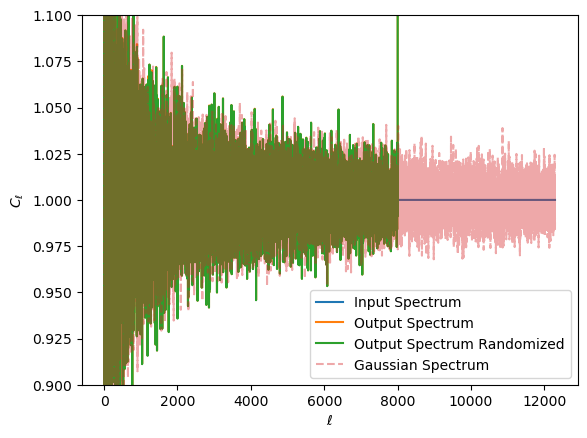

In [208]:
#plot quantities
plt.plot(ls, input_spectrum/input_spectrum, label = 'Input Spectrum')
plt.plot(lsoutmap, outmap_cl/input_spectrum, label = 'Output Spectrum')
plt.plot(lsoutmap, outmap_randomized_cl/input_spectrum, label = 'Output Spectrum Randomized')
plt.plot(lsgaussian, gaussian_cl/input_spectrum, label = 'Gaussian Spectrum', alpha = 0.4, ls = '--')
#plt.ylim(1e-10, 1e-6)
plt.ylim(0.9, 1.1)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

### Check statistical properties

In [167]:
meano, varo, skewo, lambo, meanGo, sigmaGo = get_out_quantities(outmap)

In [176]:
meano, varo, skewo

(2.7840612081932625e-06, 0.008112560108942101, 0.3683927383183255)

Text(0, 0.5, '$P(\\kappa)$')

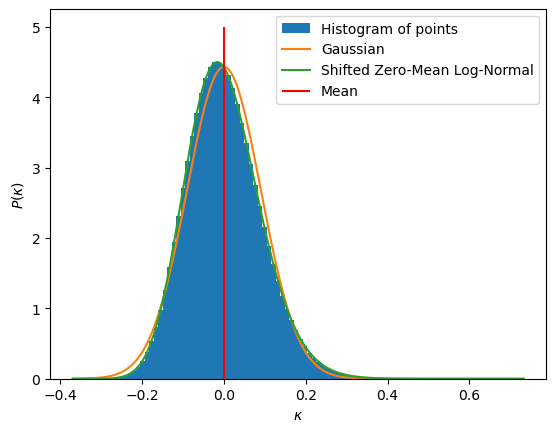

In [187]:
from scipy import stats
#create histogram of points of outmap and compare with gaussian
plt.hist(outmap, bins = 100, density = True, label = 'Histogram of points')
x = np.linspace(outmap.min(), outmap.max(), 1000)
plt.plot(x, stats.norm.pdf(x, meano, np.sqrt(varo)), label = 'Gaussian')
plt.plot(x, shifted_lognormal_zero_mean(x, sigmaGo, lamb), label = 'Shifted Zero-Mean Log-Normal')
plt.vlines(meano, 0, 5, label = 'Mean', color = 'red')
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$P(\kappa)$')


In [186]:
meano

2.7840612081932625e-06

## Skewness in function of FWHM

In [169]:
fwhms = np.arange(0.5, 6, 1.)
fwhms_deg = fwhms/60 #arcmin to deg
fwhms_rad = np.deg2rad(fwhms_deg)

In [170]:
lmax = 4000

In [218]:
results = {}
maps_in = [outmap, outmap_randomized]
names = ['Lognormal', 'Lognormal Randomized']
for n, map_in in zip(names, maps_in):
    values = []
    for fwhm, fwhm_rad in zip(fwhms, fwhms_rad):
        print(' Working on fwhm', fwhm)
        smoothed = hp.sphtfunc.smoothing(map_in, fwhm_rad, pol = False, lmax = lmax)
        skew_ = np.mean(smoothed**3)
        values += [skew_]
    values = np.array(values)
    results[n] = values
    

 Working on fwhm 0.5
 Working on fwhm 1.5
 Working on fwhm 2.5
 Working on fwhm 3.5
 Working on fwhm 4.5
 Working on fwhm 5.5
 Working on fwhm 0.5
 Working on fwhm 1.5
 Working on fwhm 2.5
 Working on fwhm 3.5
 Working on fwhm 4.5
 Working on fwhm 5.5


In [217]:
hp.write_map("lognormal_randomized_first.fits", outmap_randomized, overwrite = True)

setting the output map dtype to [dtype('float64')]


In [ ]:
hp.write_map("lognormal_first.fits", outmap, overwrite = True)

setting the output map dtype to [dtype('float64')]


In [173]:
results_sims = np.load('results.npy', allow_pickle = True).take(0)
results_G_Born = np.load('resultsG.npy', allow_pickle = True).take(0)

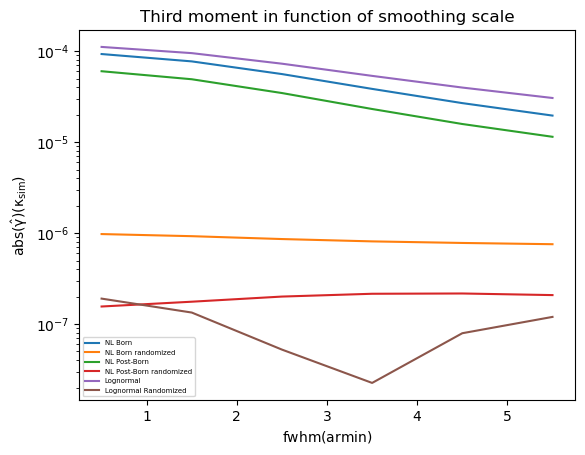

In [219]:
plt.title('Third moment in function of smoothing scale')
for k in results_sims.keys():
    skews = np.array(results_sims[k])
    plt.plot(fwhms, abs(skews), label = k)

for k, values in results.items():
    plt.plot(fwhms, abs(values), label = k)

plt.ylabel(r'$\rm{abs}(\hat{\gamma})(\kappa_{\rm{sim}})$')
plt.xlabel(r'$\rm{fwhm} (armin)$')

#plt.hlines(-1e-6, 0.5, 6, color = 'k', ls = '--', label = '-1e-6 line', alpha = 0.4)
plt.yscale('log')
plt.legend(fontsize = 5)